# EE P 590: Deep Learning for Embedded Real-time Intelligence 


# Homework 3  

In [1]:
import torch

In [2]:
from eep590_utils import * 

# 0. Warm-up (40 points) 

###  Answer the following in your own words (read and understand the concepts, do not copy answers from the internet): 


**(a.) Explain why the depth-wise separable convolutions can achieve reasonable results while using fewer parameters compared to traditional convolutions. Also compare the representation power of a depth-wise separable convolution to that of a standard convolution if both had the same number of parameters.**

Even the depth-wise separable convolution have fewer parameters than traditional convolutions, they can get the same size of output when acting on the same matrix. The less parameter means there are less prone to overfitting. Also with fewer parameters, the depth-wise separable convolution require less operations to compute, and thus are cheaper and faster.

When dealing with the same size of matrix with same size of output, the depth-wise separable convolution will have fewer parameters than traditional convolutions. If they both had the same number of parameters. The depth-wise separable convolution can make the output more width or more deeper than traditional convolution. So the representation power of a depth-wise separable convolution is better than traditional convolution.

**(b.) Comment on the quantization bit-widths (for a deep learning model) required to achieve good performance for speech/audio inputs and compare it to that for image inputs. Which type of input requires higher number of bits to achieve reasonable performance, and why?** 

Generally, I think the image input requires higher number of bits to achieve reasonable performance. Because the audio data represent by Spectrograms with frequency and time, which is a 2d data. But the image data have weight, height, and RGB color, which is 3d data. Compare with 3d data and 2d data, the 3d data should requires higher number of bits.


**(c.) From an optimization perspective, why is it challenging to train a deep learning model with quantized weights and activations?** 

The mode with quantized weight and activations will lose some accuracy. The parameters in the model could be limited by the accuracy and could not reach the optimal solution during the training process

**(d.) What is the impact of low-rank projections on the generalization ability of a deep learning model? Explain your reasoning.**
 
Using low-rank projection can reduce the dimensionality of the data to reduce the size of the model and the computational cost. At the same time, low-rank projection can reduce some unimportant details in the data feature while reducing the data dimension, thereby reducing overfitting to a certain extent and improving the performance of the model

**(e.) What is the motive to deploy deep learning models on embedded/IoT devices? List the problems associated with sending the data from the IoT device to the cloud through wifi and performing the inference on the cloud**

1. Faster Response Time
Deploying deep learning models on embedded devices saves time uploading data. In some tasks that require timely response, such as autonomous driving, the car needs to quickly identify pedestrians or obstacles on the road

2. Prevent the Instability of Network
The instability of the network will cause the device to not be able to upload or receive the data.

3. Reduce Resource Consumption
Deploying deep learning models on embedded devices eliminates the need for devices to communicate with the cloud all the time, thus saving resource consumption

**(f.) In one or more sentences, and using sketches as appropriate, explain: SqueezeNet and MobileNet. What are the defining characteristic of these architectures? How do they improve upon their predecessors in terms of latency and memory consumption?**

SqueezeNet:
SqueezeNet simplifies the network complexity of CNN. SqueezeNet uses Fire Module to convert the original simple one-layer conv layer into two layers: squeeze layer + expand layer, each with a Relu activation layer. Replacing the 3x3 convolution kernel with a 1x1 convolution kernel reduces the number of input feature maps for the input 3x3 convolution. Thus reducing the number of CNN model parameters.


MobileNet:
The MobileNet split the convolution into two parts: Depthwise and Pointwise (Separable convolution of depthwise separable convolution), and replace pooling with convolution with stride 2. By compressing the model and using efficient network computing methods, the parameters in the network are reduced. It reducing the size and computational cost of the model.

**(g.) Compare and contrast the different pruning techniques discussed in the lecture. Which technique would produce the  most optimal results? Which technique is the most practical? Explain your reasoning.**

There are two pruning method:
1. Magnitude-based method
2. Hessian-based method

The Magnitude-based method prunes the model uniformly, compressing the size of the model to make it easier to use. However, some pruning will reduce the integrity of the data information and decrease the accuracy of the model.

The Hessian-based method uses a more subtle algorithm for pruning but is more computationally expensive.

Therefore, The Hessian-based method will produce the most optimal results, and the Magnitude-based method is the most practical.

**(h.) Explain how Scree plots are useful in resource allocation and determining each layer's target rank.**

The Scree plots show the relationship between the eigenvalues and the number of factors. In the data, it can show the relationship between the number of feature reductions and the selected valid interval. 

The Screen plots can help us choose a suitable rank that can keep useful features and compress the data efficiently


**(i.) Compare and contrast the different quantization techniques discussed in the lectures, and comment on the strengths and limitations of each technique.**

There are two quantization techniques:
1. Full Quantization
2. Quantization with full-precision copy

The full quantization include fixed-point format and code book. It don't need much computational cost and can be applied easily, but it will lose the model's accuracy.

The Quantization with full-precision copy include BinaryConnect and Binary Neural Network. Through binarization, the complexity of the model can be greatly reduced and the computational cost of the model can be reduced. However, binarization will reduce the complexity of information of data and it will decrease the accuracy of the model. BNN improves the performance of some models through some scale algorithms, but this will increase the number of matrix operations, resulting in increased model training time.

# 1. Low-rank approximation (30 points) 

In this section we will use low-rank approximations of the dense layers to reduce the memory consumption of a simple  LeNet architecture during inference. To make it simpler, we have divided this into subtasks:- 

- **(8 points) Subtask 1: Train a standard LeNet architercture on the Fashion MNIST dataset. Use the `load_data_fashion_mnist` function provided in the `eep590_utils.py` file for downloading and loading the dataset. The model architecture is defined below for your convenience, but you are free to use any other implementations of the same architecture. Use a set of reasonable hyper-parameters to obtain an accuracy of at least 75 percentage on the training and testing sets.** 

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
print(LeNet())

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
net = LeNet()

In [6]:
batch_size = 10
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [7]:
# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [8]:
num_epochs = 3

for epoch in range(num_epochs): 
    train_acc = []
    test_acc = []
    for step, (X_train, y_train) in enumerate(train_iter):
        
        optimizer.zero_grad()

        # forward + backward + optimize
        y_hat = net(X_train)
        #y_predict = torch.max(y_hat, dim=1)[1]
        acc = accuracy(y_hat, y_train) / X_train.shape[0]
        train_acc.append(acc)
        loss = loss_function(y_hat, y_train)

        # backward
        loss.backward()

        # weight update
        optimizer.step()
        
    with torch.no_grad():
        for step, (X_test, y_test) in enumerate(test_iter, start=0):

            y_hat = net(X_test)
            #y_predict = torch.max(y_hat, dim=1)[1]
            test_acc.append(accuracy(y_hat, y_test) / X_test.shape[0])

    train_acc = np.mean(np.array(train_acc))
    test_acc = np.mean(np.array(test_acc))
    
    print(f'epoch {epoch+1}: train accuracy={train_acc:.3f}, test accuracy={test_acc:.3f}')

epoch 1: train accuracy=0.790, test accuracy=0.838
epoch 2: train accuracy=0.861, test accuracy=0.863
epoch 3: train accuracy=0.878, test accuracy=0.877


- **(10 points) Subtask 2: Project the `self.fc1` and `self.fc2` weights to subspaces with ranks `r1` and `r2`.** 


In [9]:
# extract weight
w1 = net.fc1.weight.detach()
w2 = net.fc2.weight.detach()

# SVD
U1, S1, V1 = torch.linalg.svd(w1, full_matrices=False)
U2, S2, V2 = torch.linalg.svd(w2, full_matrices=False)


In [10]:
import copy

r1 = int(0.1 * w1.shape[0])
r2 = int(0.1 * w2.shape[0])

def rank_weight(net, U1, S1, V1, U2, S2, V2, r1, r2):
    ranked_net = copy.deepcopy(net)
    w1_ranked = np.matmul(np.matmul(U1[:,:r1], np.diag(S1[:r1])), V1[:r1,:])
    # print(w1.shape, w1_ranked.shape)
    w2_ranked = np.matmul(np.matmul(U2[:,:r2], np.diag(S2[:r2])), V2[:r2,:])
    # print(w2.shape, w2_ranked.shape)

    ranked_net.fc1.weight.data = torch.Tensor(w1_ranked)
    ranked_net.fc2.weight.data = torch.Tensor(w2_ranked)
    return ranked_net

new_net = rank_weight(net, U1, S1, V1, U2, S2, V2, r1, r2)

- **(4 points) Plot a graph with the X-axis representing the %improvement in memory usage of the architure, and on Y-axis the test accuracy of the model. (Hint: play with `r1` and `r2`, and run the inference multiple times. You need not re-train the model)** 
- **(4 points) Plot a graph of the %improvement in memory usage vs. $\beta$, which is the percentage of total variation explained in the low-rank subspace. (Hint: Refer to slide 42 of the lecture)**
- **(4 points) Plot a graph of test accuracy vs. $\beta$.** 

To calculate the memory usage, I search the internet but only found the method to calculate the memory usage of pytorch model on GPU use `torch.cuda.memory_allocated()`. I don't have GPU on my computer and running my model using CPU. So I calculate the parameter instead.

In [11]:
# def memory_usage(model):
#     mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
#     mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
#     mem = mem_params + mem_bufs
#     print(mem)
#     return mem

# init_mem = memory_usage(net)

In [28]:
n = w1.shape[0]
r1_rate = [0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.35]
r1_ls = [int(x * n) for x in r1_rate]
r2_rate = [0.5]
r2_ls = [int(x * n) for x in r2_rate]

m1,k1 = w1.shape
m2,k2 = w2.shape

rank_test_acc_ls = []
mem_improve_ls = []
beta_ls = []

for r1 in r1_ls:
    for r2 in r2_ls:
        test_acc = []

        ranked_net = rank_weight(net, U1, S1, V1, U2, S2, V2, r1, r2)

        with torch.no_grad():
            for step, (X_test, y_test) in enumerate(test_iter, start=0):

                y_hat = ranked_net(X_test)
                #y_predict = torch.max(y_hat, dim=1)[1]
                test_acc.append(accuracy(y_hat, y_test) / X_test.shape[0])

        test_acc = round(np.mean(np.array(test_acc)), 3)
        print(f'r1: {r1}, r2: {r2}', end='  ')
        print('Acc =', test_acc, end='  ')
        rank_test_acc_ls.append(test_acc)

        # memory
        improve = round(((m1 * k1 + m2 * k2) / (m1 * r1 + r1 + r1 * k1 + m2 * r2 + r2 + r2 * k2) - 1) * 100, 1)
        print('%improvement =',improve, end='  ')
        mem_improve_ls.append(improve)

        beta = round((torch.sum(S1[:r1]**2).item() + torch.sum(S2[:r2]**2).item()) / (torch.sum(S1**2).item() + torch.sum(S2**2).item()), 3)
        print('Beta =', beta)
        beta_ls.append(beta)

        


r1: 3, r2: 60  Acc = 0.36  %improvement = 319.0  Beta = 0.411
r1: 6, r2: 60  Acc = 0.666  %improvement = 276.5  Beta = 0.588
r1: 8, r2: 60  Acc = 0.794  %improvement = 252.7  Beta = 0.677
r1: 12, r2: 60  Acc = 0.85  %improvement = 213.1  Beta = 0.775
r1: 18, r2: 60  Acc = 0.864  %improvement = 167.9  Beta = 0.847
r1: 24, r2: 60  Acc = 0.873  %improvement = 134.2  Beta = 0.888
r1: 42, r2: 60  Acc = 0.876  %improvement = 69.9  Beta = 0.946


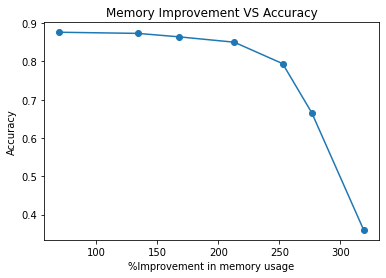

In [29]:
acc_mem_ls = [x for x in zip(mem_improve_ls, rank_test_acc_ls)]
acc_mem_ls.sort()

plt.xlabel('%Improvement in memory usage')
plt.ylabel('Accuracy')
plt.plot(*zip(*acc_mem_ls))
plt.scatter(*zip(*acc_mem_ls))
plt.title('Memory Improvement VS Accuracy')
plt.show()

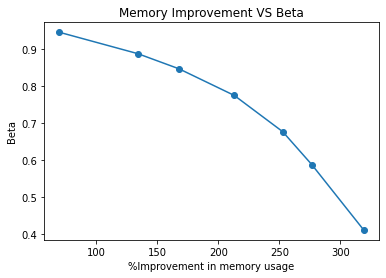

In [30]:
mem_beta_ls = [x for x in zip(mem_improve_ls, beta_ls)]
mem_beta_ls.sort()

plt.xlabel('%Improvement in memory usage')
plt.ylabel('Beta')
plt.plot(*zip(*mem_beta_ls))
plt.scatter(*zip(*mem_beta_ls))
plt.title('Memory Improvement VS Beta')
plt.show()

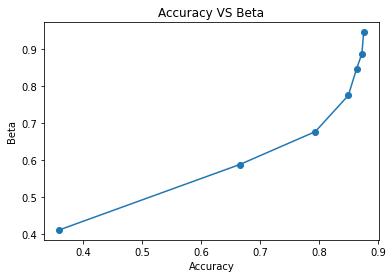

In [31]:
acc_beta_ls = [x for x in zip(rank_test_acc_ls, beta_ls)]
acc_beta_ls.sort()

plt.xlabel('Accuracy')
plt.ylabel('Beta')
plt.plot(*zip(*acc_beta_ls))
plt.scatter(*zip(*acc_beta_ls))
plt.title('Accuracy VS Beta')
plt.show()

# 2. Sparsification (30 points) 

In this section we will attempt to sparsify the model trained in subtask 1 of previous section. 

- **Subtask 1: Plot a histogram of the distribution of all the weights in the model.** 
- **Subtask 2: Implement a module to clip all the weights that have a magntude less than a threshold (say $\alpha$) to zero.**
- **Subtask 3: Run inference for different levels of sparsity by varying $\alpha$, and plot a graph of sparsity vs. test accuracy.** 

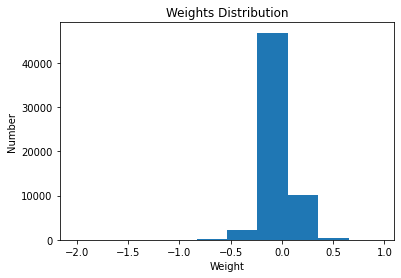

In [16]:
w_conv1= net.conv1.weight.detach().numpy()
w_conv2= net.conv2.weight.detach().numpy()
w_fc1= net.fc1.weight.detach().numpy()
w_fc2= net.fc2.weight.detach().numpy()
w_fc3= net.fc3.weight.detach().numpy()

all_w = list(w_conv1.reshape(-1)) + list(w_conv2.reshape(-1)) + list(w_fc1.reshape(-1)) + list(w_fc2.reshape(-1)) + list(w_fc3.reshape(-1))

plt.hist(all_w)
plt.title('Weights Distribution')
plt.xlabel('Weight')
plt.ylabel('Number')
plt.show()

In [17]:
def clip_net(net, alpha, w_conv1, w_conv2, w_fc1, w_fc2, w_fc3):

    clipped_net = copy.deepcopy(net)

    w_conv1_clip=copy.deepcopy(w_conv1)
    w_conv2_clip=copy.deepcopy(w_conv2)
    w_fc1_clip=copy.deepcopy(w_fc1)
    w_fc2_clip=copy.deepcopy(w_fc2)
    w_fc3_clip=copy.deepcopy(w_fc3)

    w_conv1_clip[np.abs(w_conv1)<alpha]=0
    w_conv2_clip[np.abs(w_conv2)<alpha]=0
    w_fc1_clip[np.abs(w_fc1)<alpha]=0
    w_fc2_clip[np.abs(w_fc2)<alpha]=0
    w_fc3_clip[np.abs(w_fc3)<alpha]=0

    params_num = np.count_nonzero(w_conv1_clip) + np.count_nonzero(w_conv2_clip) + np.count_nonzero(w_fc1_clip) + np.count_nonzero(w_fc2_clip) + np.count_nonzero(w_fc3_clip)
    
    clipped_net.conv1.weight.data = torch.Tensor(w_conv1_clip)
    clipped_net.conv2.weight.data = torch.Tensor(w_conv2_clip)
    clipped_net.fc1.weight.data = torch.Tensor(w_fc1_clip)
    clipped_net.fc2.weight.data = torch.Tensor(w_fc2_clip)
    clipped_net.fc3.weight.data = torch.Tensor(w_fc3_clip)
    
    return clipped_net, params_num

In [22]:
alphas = [0.03, 0.06, 0.1, 0.15, 0.2, 0.3]
alpha_test_acc_ls = []
sparsity_ls = []

init_num = len(all_w)

for alpha in alphas:

    print("alpha:", alpha, end=' ')
    
    clipped_net, params_num = clip_net(net, alpha, w_conv1, w_conv2, w_fc1, w_fc2, w_fc3)
    test_acc = []
    with torch.no_grad():
        for step, (X_test, y_test) in enumerate(test_iter, start=0):

            y_hat = clipped_net(X_test)
            #y_predict = torch.max(y_hat, dim=1)[1]
            test_acc.append(accuracy(y_hat, y_test) / X_test.shape[0])
               
    test_acc = round(np.mean(np.array(test_acc)),4)
    print("Test_acc:", test_acc, end=' ')
    alpha_test_acc_ls.append(test_acc)

    sparsity = round(params_num / init_num, 6)
    print("Sparsity:", sparsity)
    sparsity_ls.append(sparsity)

alpha: 0.03 Test_acc: 0.8781 Sparsity: 0.661269
alpha: 0.06 Test_acc: 0.8723 Sparsity: 0.405361
alpha: 0.1 Test_acc: 0.8599 Sparsity: 0.25183
alpha: 0.15 Test_acc: 0.7985 Sparsity: 0.157375
alpha: 0.2 Test_acc: 0.6733 Sparsity: 0.09875
alpha: 0.3 Test_acc: 0.1001 Sparsity: 0.036816


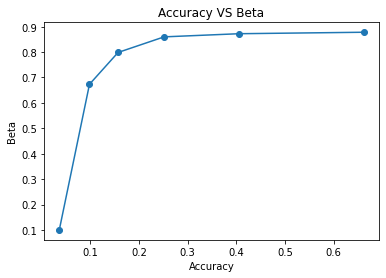

In [23]:
sparsity_acc_ls = [x for x in zip(sparsity_ls, alpha_test_acc_ls)]
sparsity_acc_ls.sort()

plt.xlabel('Accuracy')
plt.ylabel('Beta')
plt.plot(*zip(*sparsity_acc_ls))
plt.scatter(*zip(*sparsity_acc_ls))
plt.title('Accuracy VS Beta')
plt.show()

# 3. Improved RNN (35 points)

In this section we will implement a different type of RNN, one with weighted residual connections, and try to analyze it's usefulness. 

Let $X = [x 1 , . . . , x^T ]$ be the input data where $x_t \in R^D$ denotes the t-th step feature vector. Then,
the goal of multi-class RNNs is to learn a function F : R D×T → {1, . . . , L} that predicts one of L
classes for the given data point X. Standard RNN architecture has a provision to produce an output
at every time step, but we focus on the setting where each data point is associated with a single label
that is predicted at the end of the time horizon T . Standard RNN maintains a vector of hidden state
$h_t ∈ R^D̂$ which captures temporal dynamics in the input data, i.e., $$h_t = f(W \, x_t + U \, h_{t-1} + b)$$

Learning U, W in the above architecture is difficult as the gradient
can have exponentially large (in T) condition number, which leads to problems like exploding or vanishing gradients. Instead, ImprovedRNN will use a simple weighted residual connection to perform updates of the hidden state $h_t$ as follows: $$ h̃_t = f(Wx_t + Uh_{t−1} + b)$$  $$h_t = \alpha h̃_t + βh_{t−1} $$

where 0 ≤ α, β ≤ 1 are trainable scalar weights.


- **(20 points) Subtask 1: Implement the `ImprovedRNNCell` by extending the RNNCell defined in `eep590_utils.py`, which extends `nn.Module` in pytorch.** 

In [20]:
class ImprovedRNNCell(RNNCell):
    '''
    ImprovedRNN Cell with both Full Rank and Low Rank Formulations
    Has multiple activation functions for the gates
    hidden_size = # hidden units
    update_nonlinearity = nonlinearity for final rnn update
    can be chosen from [tanh, sigmoid, relu, quantTanh, quantSigm]
    wRank = rank of W matrix (creates two matrices if not None)
    uRank = rank of U matrix (creates two matrices if not None)
    wSparsity = intended sparsity of W matrix(ces)
    uSparsity = intended sparsity of U matrix(ces)
    The cell will not automatically sparsify. The user must invoke .sparsify() to hard threshold.
    alphaInit = init for alpha, the update scalar
    betaInit = init for beta, the weight for previous state
    Basic architecture is like:
    h_t^ = update_nl(Wx_t + Uh_{t-1} + B_h)
    h_t = sigmoid(beta)*h_{t-1} + sigmoid(alpha)*h_t^
    W and U can further parameterised into low rank version by
    W = matmul(W_1, W_2) and U = matmul(U_1, U_2)
    '''

    def __init__(self, input_size, hidden_size,
                 update_nonlinearity="tanh", wRank=None, uRank=None,
                 wSparsity=1.0, uSparsity=1.0, alphaInit=-3.0, betaInit=3.0,
                 name="ImprovedRNN"):
        super(ImprovedRNNCell, self).__init__(input_size, hidden_size,
                                           None, update_nonlinearity,
                                           1, 1, 1, wRank, uRank, wSparsity,
                                           uSparsity)
        # TODO: Initialize all the required variables

        if wRank == None:
            self.W = nn.Parameter(0.1 * torch.randn([input_size, hidden_size]))
        else:
            self.W1 = nn.Parameter(0.1 * torch.randn([input_size, wRank]))
            self.W2 = nn.Parameter(0.1 * torch.randn([wRank, hidden_size]))

        if uRank == None:
            self.U = nn.Parameter(0.1 * torch.randn([hidden_size, hidden_size]))
        else:
            self.U1 = nn.Parameter(0.1 * torch.randn([hidden_size, uRank]))
            self.U2 = nn.Parameter(0.1 * torch.randn([uRank, hidden_size]))

        self.bias_update = nn.Parameter(torch.ones([1, hidden_size]))
        self.alpha = nn.Parameter(alphaInit * torch.ones([1, 1]))
        self.beta = nn.Parameter(betaInit * torch.ones([1, 1]))


    @property
    def name(self):
        return self._name

    @property
    def cellType(self):
        return "ImprovedRNN"

    def forward(self, input, state):
        # TODO: Implement the forward pass to compute the new_state

        if self.W != None:
            w_c = torch.matmul(input, self.W)
        else:
            w_c = torch.matmul(torch.matmul(input, self.W1), self.W2)

        if self.U != None:
            u_c = torch.matmul(state, self.U)
        else:
            u_c = torch.matmul(torch.matmul(state, self.U1), self.U2)

        c = w_c + u_c + self.bias_update

        new_state = torch.sigmoid(self.beta) * state + torch.sigmoid(self.alpha) * c

        return new_state

- **(10 points) Subtask 2: Explain how Improved RNN resolves some of the problems in traditional RNNs from an optimization perspective.** Assume that the label decision function is one dimensional and is given by $f (X) = v^⊤ h_T$ . Let $L(X, y; θ) = L(f (X), y; θ)$ be the logistic loss function for the given labeled data point $(X, y)$ and with parameters $θ = (W, U, v)$. Then, check the gradients $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial U}$. A critical term in the expression of the gradients that determines whether it explodes/vanishes will be: $$M(U) = \prod_{k=t}^{T-1} (αU^T D_{k+1} + βI)$$ where $D_k = diag(σ′ (Wx_k + Uh_{k−1} + b))$ is the Jacobian matrix of the pointwise nonlinearity. **Hint: Analyze the range of possible values for the condition number $\kappa$ of the matrix $M(U)$**. 


From the $M(U)$, we can get the range of condition number $k$:
$$ k \le \frac{(1+\frac{\alpha}{\beta} \max _k||U^T D_{k+1}||)^{T-t}}{(1-\frac{\alpha}{\beta} \max _k||U^T D_{k+1}||)^{T-t}} $$

If $\alpha$ = 1 and $\beta$ = 0. The gradient condition number of a standard RNN can be an exponential of T. This means that, relative to the mean eigenvalue, the gradient can grow or disappear infinitely in some directions, resulting in instability during training.
In contrast to standard RNNs, the condition number κM(U) of FastRNNs is bounded, bounded by a small term. By using residual connections, FastRNN is able to solve this problem and thus has a faster training speed and a more accurate model compared to traditional RNNs.


- **(5 points) Subtask 3: Explain why this result is useful in the context of embedded real-time applications. Comment on representation power, memory-usage, and computation.** 

The improved RNN compared to the traditional RNN have the higher representation power with reduced computation and reduced model size. It reduces the memory-usage, and training time.

The smaller models size and faster training time make is useful in the embedded real-time applications

# 4. References & Misc. (15 points) 

**(a.) How many hours (approx) did you spend on this assignment totally? Document and explain your journey, including the issues/challenges you faced (both technical and non-technical).**



I probably spent over 40 hours on this assignment.

There are two main challenges in finish this homework.
First is the conceptual questions. Although they have been mentioned in class, in order to answer these conceptual questions, I need to fully understand these concepts, which led me to spend a long time looking for relevant materials and understanding concepts.

The second is the coding. Before this class, I didn't have any experience with pytorch. I only knew a few about traditional machine learning, and didn't know much about the model and application of deep learning. So it took a long time to find and learn how to use some function in pytorch to finish the homework.

**(b.) Cite all the resources and references you consulted to complete this assignment.** 

[1] Depth-wise Separable Convolutions for ML. https://eli.thegreenplace.net/2018/depthwise-separable-convolutions-for-machine-learning/

[2] Audio Deep Learning https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

[3] Scree Plot https://sanchitamangale12.medium.com/scree-plot-733ed72c8608

[4] SqueezeNet https://blog.csdn.net/wfei101/article/details/77279547

[5] SqueezeNet https://cloud.tencent.com/developer/article/1424934

[6] MobileNet Essay https://arxiv.org/abs/1704.04861

[7] MobileNet https://lixudong.ink/2019/12/13/MobileNet系列/

[8] Pytorch RNN https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html

[9] Fast RNN https://arxiv.org/abs/1901.02358

[10] Different RNN https://zhuanlan.zhihu.com/p/40986674